## Importing Libraries

In [23]:
import os
import pathlib
import glob
import subprocess
import threading 
import time
from IPython.display import clear_output
import matplotlib.pyplot as plt
import statistics
import seaborn as sns
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore')
import numpy as np
import matplotlib.pyplot as plt
import time
import librosa
import librosa.display
import IPython.display as ipd

from pydub import AudioSegment
from pydub.utils import mediainfo
from sklearn.metrics import plot_confusion_matrix, classification_report, accuracy_score

In [2]:
# input parameters
source_folder = "D:\echo unsupervised bird redo"

# options are currently ".mp3" or ".wav" (there is scope to add more)
output_file_type = ".wav"

### Generate list of all folders in the source path

In [3]:
sub_folders = pathlib.Path(source_folder).glob("**/*") #generator object
sub_folders
sub_folder_paths = [x for x in sub_folders if x.is_dir()]
print(len(sub_folder_paths))
sub_folder_paths[:4]

2


[WindowsPath('D:/echo unsupervised bird redo/part3'),
 WindowsPath('D:/echo unsupervised bird redo/part4')]

### Generate list of all audio files paths in the sub-folder

In [4]:
# this creates a new version of the input file, converted to the output format
def convert_file(input_file_path):
    parent_path = pathlib.PurePath(input_file_path).parent    
    file_name = pathlib.Path(input_file_path).stem   
    output_file_path = str(parent_path) + "/" + file_name + output_file_type
    # write the new wav file forcing overwrite 
    subprocess.call(['ffmpeg', '-y', '-i', input_file_path,
                 output_file_path],
    stdout=subprocess.DEVNULL,
    stderr=subprocess.STDOUT)
    return

In [5]:
# check each file type and convert it if necessary
# if creates a new version of the file, then deletes the old
# it skips over the file if it is already in the output format

def check_file_type(audio_file_path):  
    # check this file name and return if it already exists
    if (pathlib.Path(audio_file_path).suffix == output_file_type): return
# audio file type conversions
    if (pathlib.Path(audio_file_path).suffix == ".wav"): convert_file(audio_file_path); # print("wav")
    if (pathlib.Path(audio_file_path).suffix == ".mp3"): convert_file(audio_file_path); # print("mp3")
    if (pathlib.Path(audio_file_path).suffix == ".flac"): convert_file(audio_file_path); # print("flac")
    if (pathlib.Path(audio_file_path).suffix == ".ogg"): convert_file(audio_file_path); # print("ogg")
# video file type conversions:
    if (pathlib.Path(audio_file_path).suffix == ".m4a"): convert_file(audio_file_path)
    if (pathlib.Path(audio_file_path).suffix == ".mp4"): convert_file(audio_file_path)
# delete the old file
    os.remove(audio_file_path)
    return

In [6]:
# this function is called by each thread
# it takes a subfolder within the input directory and iterates through every file within it
# to convert to output format

def threaded_function(sub_folder_path):
    audio_files = pathlib.Path(sub_folder_path).glob("**/*") #generator object
    audio_files
    audio_file_paths =  [x for x in audio_files if x.is_file()] #PosixPath list
    for x in range(len(audio_file_paths)): 
        check_file_type(audio_file_paths[x])
    print("folder {} done".format(sub_folder_path.stem))
    time.sleep(1)
    clear_output()
    return


In [7]:
# create a list of threads
# the list is currently set to the number of folders

def create_threads(sub_folder_paths):
    max_threads = lambda x : 10 if (x > 10) else x
    num_threads =  max_threads(len(sub_folder_paths))
    num_threads = len(sub_folder_paths)
    thread_list = []
    for i in range(num_threads):
        thread_list.append(threading.Thread(target=threaded_function, args=([sub_folder_paths[i]])))  
    return thread_list

### Main function that converts all files to the specified format

In [8]:
# create a thread for every folder
thread_list = create_threads(sub_folder_paths)
# start converting files in each folder concurrently
for thread in thread_list:
    thread.start()
# wait for all threads to complete
for thread in thread_list:
    thread.join()
print("done all")
print("Conversion of {}\n to format \"{}\" complete!".format(source_folder, output_file_type))

done all
Conversion of D:\echo unsupervised bird redo
 to format ".wav" complete!


### Exploratory Data Analysis (EDA)

In [9]:
def count_audio_files(folder_path):
    audio_extensions = ['.mp3', '.flac', '.wav']
    num_files = len([filename for filename in os.listdir(folder_path) 
                     if os.path.isfile(os.path.join(folder_path, filename)) 
                     and any(filename.endswith(ext) for ext in audio_extensions)])
    return num_files

folder_path_1 = "D:/echo unsupervised bird redo/part3"
num_audio_files_1 = count_audio_files(folder_path_1)
folder_path_2 = "D:/echo unsupervised bird redo/part4"
num_audio_files_2 = count_audio_files(folder_path_2)
print(f"Number of audio files in the folder-1: {num_audio_files_1}")
print(f"Number of audio files in the folder-2: {num_audio_files_2}")

Number of audio files in the folder-1: 1006
Number of audio files in the folder-2: 891


### Making a dataframe for data manipulation

In [10]:
import os
import librosa
import pandas as pd
from pathlib import Path

def load_wav_files_into_dataframe(folder_path):
    data = []
    for root, _, files in os.walk(folder_path):
        for filename in files:
            if filename.endswith('.wav'):
                file_path = os.path.join(root, filename)
                try:
                    audio, sr = librosa.load(file_path, sr=None)
                    duration = librosa.get_duration(y=audio, sr=sr)
                    data.append({'file_path': file_path, 'filename': filename, 'sampling_rate': sr, 'duration': duration})
                except Exception as e:
                    print(f"Error loading {filename}: {str(e)}")
    
    df = pd.DataFrame(data)
    return df

# Load ".wav" files into a DataFrame
source_folder = "D:/echo unsupervised bird redo"
df = load_wav_files_into_dataframe(source_folder)

# Display the DataFrame
print(df)


                                              file_path       filename  \
0     D:/echo unsupervised bird redo\part3\187729091...  187729091.wav   
1     D:/echo unsupervised bird redo\part3\187729521...  187729521.wav   
2     D:/echo unsupervised bird redo\part3\187731871...  187731871.wav   
3     D:/echo unsupervised bird redo\part3\187731881...  187731881.wav   
4     D:/echo unsupervised bird redo\part3\187734321...  187734321.wav   
...                                                 ...            ...   
1892  D:/echo unsupervised bird redo\part4\214375401...  214375401.wav   
1893  D:/echo unsupervised bird redo\part4\214381141...  214381141.wav   
1894  D:/echo unsupervised bird redo\part4\214381771...  214381771.wav   
1895  D:/echo unsupervised bird redo\part4\214382381...  214382381.wav   
1896  D:/echo unsupervised bird redo\part4\214382731...  214382731.wav   

      sampling_rate    duration  
0             48000    9.069646  
1             48000    3.962250  
2        

In [11]:
df

,file_path,filename,sampling_rate,duration
0,D:/echo unsupervised bird redo\part3\187729091...,187729091.wav,48000,9.069646
1,D:/echo unsupervised bird redo\part3\187729521...,187729521.wav,48000,3.962250
2,D:/echo unsupervised bird redo\part3\187731871...,187731871.wav,48000,5.313521
3,D:/echo unsupervised bird redo\part3\187731881...,187731881.wav,48000,26.605250
4,D:/echo unsupervised bird redo\part3\187734321...,187734321.wav,48000,11.974063
...,...,...,...,...
1892,D:/echo unsupervised bird redo\part4\214375401...,214375401.wav,44100,24.920816
1893,D:/echo unsupervised bird redo\part4\214381141...,214381141.wav,96000,53.490000
1894,D:/echo unsupervised bird redo\part4\214381771...,214381771.wav,44100,100.471655
1895,D:/echo unsupervised bird redo\part4\214382381...,214382381.wav,96000,54.759000


## Pitch Extraction from Audio Files using Librosa

**Code defines a function extract_min_max_pitch that takes an audio time series y and its sampling rate sr as input and returns the minimum and maximum pitch frequencies detected in the audio, excluding zero values. It uses the librosa library for audio processing.**

In [12]:
import librosa
import numpy as np
import pandas as pd

def extract_min_max_pitch(y, sr):
    """
    Extract the minimum and maximum pitch frequencies from an audio signal, excluding zeros.
    
    Args:
    - y: Audio time series.
    - sr: Sampling rate of y.
    
    Returns:
    - (min_pitch, max_pitch): A tuple containing the minimum and maximum pitch frequencies.
    """
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    # Flatten the array and filter out 0 values
    non_zero_pitches = pitches[pitches > 0].flatten()
    
    if len(non_zero_pitches) == 0:  # If no pitches detected, return zeros
        return (0, 0)
    
    min_pitch = np.min(non_zero_pitches)
    max_pitch = np.max(non_zero_pitches)
    
    return (min_pitch, max_pitch)

# Initialize lists to store min and max pitches for each file
min_pitches = []
max_pitches = []

# Iterate through each row in the DataFrame
for index, row in df.iterrows():
    # Load the audio file
    y, sr = librosa.load(row['file_path'], sr=None)
    
    # Extract min and max pitch
    min_pitch, max_pitch = extract_min_max_pitch(y, sr)
    
    # Append to lists
    min_pitches.append(min_pitch)
    max_pitches.append(max_pitch)

# Add the min and max pitches as new columns to the DataFrame
df['min_pitch'] = min_pitches
df['max_pitch'] = max_pitches

# Display the first few rows to verify the new columns
print(df.head())



                                           file_path       filename  \
0  D:/echo unsupervised bird redo\part3\187729091...  187729091.wav   
1  D:/echo unsupervised bird redo\part3\187729521...  187729521.wav   
2  D:/echo unsupervised bird redo\part3\187731871...  187731871.wav   
3  D:/echo unsupervised bird redo\part3\187731881...  187731881.wav   
4  D:/echo unsupervised bird redo\part3\187734321...  187734321.wav   

   sampling_rate   duration   min_pitch    max_pitch  
0          48000   9.069646  153.104935  3995.882812  
1          48000   3.962250  153.333115  3996.012207  
2          48000   5.313521  152.475082  3992.306885  
3          48000  26.605250  152.427460  3996.077881  
4          48000  11.974063  152.662949  3993.209961  


## Mean Spectral Bandwidth Calculation

**The code calculates the mean spectral bandwidth of audio files stored in a DataFrame and filters them based on a threshold for voice recognition. It adds a new column with mean spectral bandwidth values, filters files within a specific bandwidth range, and prints the count of valid files along with the total number of files. This process helps identify suitable audio files for voice recognition based on spectral characteristics.**

In [13]:
def calculate_mean_spectral_bandwidth(file_path, sr=16000):
    """
    Calculate the mean spectral bandwidth of an audio file.
    
    Args:
    - file_path: Path to the audio file.
    - sr: Sampling rate to use for loading the audio.
    
    Returns:
    - Mean spectral bandwidth of the audio file.
    """
    y, sr = librosa.load(file_path, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    mean_spec_bw = np.mean(spec_bw)
    return mean_spec_bw

# Add a new column to CREMA_df for the mean spectral bandwidths
df['mean_spectral_bandwidth'] = df['file_path'].apply(calculate_mean_spectral_bandwidth)

# Define the maximum spectral bandwidth for voice recognition
max_bw_for_voice_recognition = 4000  # Hz

# Filter the DataFrame for audio files that lie within the required spectral bandwidth range
valid_bw_files_df = df[df['mean_spectral_bandwidth'] <= max_bw_for_voice_recognition]

# Count the number of files that meet the criterion
num_valid_bw_files = len(valid_bw_files_df)

print(f"Number of audio files within the required spectral bandwidth range for voice recognition: {num_valid_bw_files}")
print(f"Total number of audio files: {len(df)}")

Number of audio files within the required spectral bandwidth range for voice recognition: 1897
Total number of audio files: 1897


In [14]:
df

,file_path,filename,sampling_rate,duration,min_pitch,max_pitch,mean_spectral_bandwidth
0,D:/echo unsupervised bird redo\part3\187729091...,187729091.wav,48000,9.069646,153.104935,3995.882812,1761.494220
1,D:/echo unsupervised bird redo\part3\187729521...,187729521.wav,48000,3.962250,153.333115,3996.012207,1452.741787
2,D:/echo unsupervised bird redo\part3\187731871...,187731871.wav,48000,5.313521,152.475082,3992.306885,1940.305070
3,D:/echo unsupervised bird redo\part3\187731881...,187731881.wav,48000,26.605250,152.427460,3996.077881,1744.648435
4,D:/echo unsupervised bird redo\part3\187734321...,187734321.wav,48000,11.974063,152.662949,3993.209961,1957.149901
...,...,...,...,...,...,...,...
1892,D:/echo unsupervised bird redo\part4\214375401...,214375401.wav,44100,24.920816,140.018982,3992.591797,1159.379742
1893,D:/echo unsupervised bird redo\part4\214381141...,214381141.wav,96000,53.490000,164.109970,4007.565430,1609.157647
1894,D:/echo unsupervised bird redo\part4\214381771...,214381771.wav,44100,100.471655,139.969604,3994.238525,1511.148356
1895,D:/echo unsupervised bird redo\part4\214382381...,214382381.wav,96000,54.759000,164.134033,4007.597168,1669.552561


In [15]:
df_new = df.copy()

## RMS Loudness Level Calculation in dBFS

**The code computes the RMS loudness level in dBFS for audio files in a DataFrame (df_new). It adds a new column with these values and displays the DataFrame with the added column. This enables the analysis of audio loudness levels in decibels relative to full scale.**

In [16]:
def calculate_rms_loudness_dbfs(file_path):
    """
    Calculate the RMS loudness level of an audio file in dBFS.
    
    Args:
    - file_path: Path to the audio file.
    
    Returns:
    - RMS loudness level of the audio file in dBFS.
    """
    y, sr = librosa.load(file_path, sr=None)
    # Calculate the RMS value
    S, phase = librosa.magphase(librosa.stft(y))
    rms = librosa.feature.rms(S=S).mean()
    # Convert to dBFS
    rms_dbfs = librosa.power_to_db(rms, ref=1.0)  # Assuming max amplitude of 1 is 0 dBFS
    return rms_dbfs

# Calculate the RMS loudness in dBFS for each audio file and add it as a new column
df_new['rms_loudness_db'] = df_new['file_path'].apply(calculate_rms_loudness_dbfs)

# Display the DataFrame with the new 'rms_loudness_db' column
print(df_new.head())

                                           file_path       filename  \
0  D:/echo unsupervised bird redo\part3\187729091...  187729091.wav   
1  D:/echo unsupervised bird redo\part3\187729521...  187729521.wav   
2  D:/echo unsupervised bird redo\part3\187731871...  187731871.wav   
3  D:/echo unsupervised bird redo\part3\187731881...  187731881.wav   
4  D:/echo unsupervised bird redo\part3\187734321...  187734321.wav   

   sampling_rate   duration   min_pitch    max_pitch  mean_spectral_bandwidth  \
0          48000   9.069646  153.104935  3995.882812              1761.494220   
1          48000   3.962250  153.333115  3996.012207              1452.741787   
2          48000   5.313521  152.475082  3992.306885              1940.305070   
3          48000  26.605250  152.427460  3996.077881              1744.648435   
4          48000  11.974063  152.662949  3993.209961              1957.149901   

   rms_loudness_db  
0       -18.369985  
1       -20.024362  
2       -24.257099  
3 

## Evaluation of RMS Loudness Levels 

**The code defines ideal RMS loudness levels for voice recognition and assesses the number of audio files needing amplification (too quiet) or gain reduction (too loud) based on these ideals. It computes the counts and percentages of files requiring adjustment and prints the results. This analysis helps in identifying files that may need volume adjustments to meet optimal loudness criteria for voice recognition.**

In [17]:
# Define ideal RMS loudness levels (in dBFS) for voice recognition
ideal_min_rms_dbfs = -23  # Minimum ideal RMS loudness level
ideal_max_rms_dbfs = -20  # Maximum ideal RMS loudness level

# Assuming 'rms_loudness_db' is a column in CREMA_df representing RMS loudness in dBFS
# Count files needing amplification (too quiet)
files_needing_amplification = df_new[df_new['rms_loudness_db'] < ideal_min_rms_dbfs].shape[0]

# Count files needing gain reduction (too loud)
files_needing_gain_reduction = df_new[df_new['rms_loudness_db'] > ideal_max_rms_dbfs].shape[0]

# Print the counts
print(f"Number of files needing amplification (too quiet): {files_needing_amplification}")
print(f"Number of files needing gain reduction (too loud): {files_needing_gain_reduction}")

# Total number of files evaluated
total_files_evaluated = df_new.shape[0]

# Printing the percentage of files needing adjustment
percentage_needing_amplification = (files_needing_amplification / total_files_evaluated) * 100
percentage_needing_gain_reduction = (files_needing_gain_reduction / total_files_evaluated) * 100

print(f"Percentage of files needing amplification: {percentage_needing_amplification:.2f}%")
print(f"Percentage of files needing gain reduction: {percentage_needing_gain_reduction:.2f}%")

Number of files needing amplification (too quiet): 772
Number of files needing gain reduction (too loud): 735
Percentage of files needing amplification: 40.70%
Percentage of files needing gain reduction: 38.75%


In [18]:
df_new.drop(columns=['file_path'], inplace=True)

In [19]:
df_new

,filename,sampling_rate,duration,min_pitch,max_pitch,mean_spectral_bandwidth,rms_loudness_db
0,187729091.wav,48000,9.069646,153.104935,3995.882812,1761.494220,-18.369985
1,187729521.wav,48000,3.962250,153.333115,3996.012207,1452.741787,-20.024362
2,187731871.wav,48000,5.313521,152.475082,3992.306885,1940.305070,-24.257099
3,187731881.wav,48000,26.605250,152.427460,3996.077881,1744.648435,-21.421558
4,187734321.wav,48000,11.974063,152.662949,3993.209961,1957.149901,-26.821197
...,...,...,...,...,...,...,...
1892,214375401.wav,44100,24.920816,140.018982,3992.591797,1159.379742,-18.114852
1893,214381141.wav,96000,53.490000,164.109970,4007.565430,1609.157647,-19.695490
1894,214381771.wav,44100,100.471655,139.969604,3994.238525,1511.148356,-21.608902
1895,214382381.wav,96000,54.759000,164.134033,4007.597168,1669.552561,-20.173187


## Feature Scaling for K-Means Clustering

In [21]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

features = df_new[['sampling_rate', 'duration', 'min_pitch', 'max_pitch', 'mean_spectral_bandwidth', 'rms_loudness_db']].values
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

## Correlation Analysis of Audio Features

<AxesSubplot:>

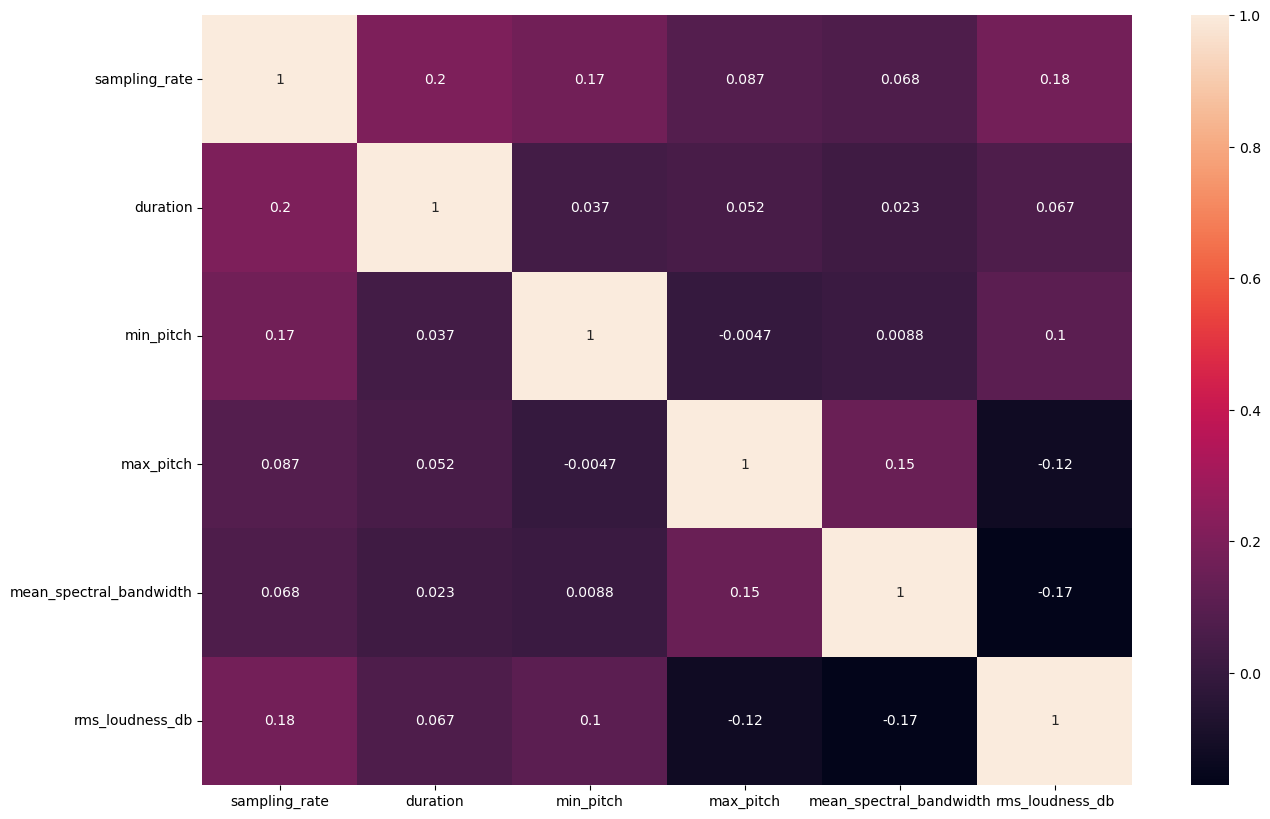

In [24]:
#Correlation matrix
df_new.corr()

#Correlation heatmap
plt.figure(figsize=(15,10))
sns.heatmap(df_new.corr(), annot = True)

## Determining Optimal Number of Clusters: Elbow Method

For cluster = 1, SSE/WCSS is 11381.999999999996
For cluster = 2, SSE/WCSS is 9358.119900699778
For cluster = 3, SSE/WCSS is 7911.219277432469
For cluster = 4, SSE/WCSS is 6598.212681638161
For cluster = 5, SSE/WCSS is 5282.336068970666
For cluster = 6, SSE/WCSS is 4413.649649781388
For cluster = 7, SSE/WCSS is 3625.2490778725814
For cluster = 8, SSE/WCSS is 3313.0936154918177
For cluster = 9, SSE/WCSS is 3014.848391258063
For cluster = 10, SSE/WCSS is 2754.4093152747832


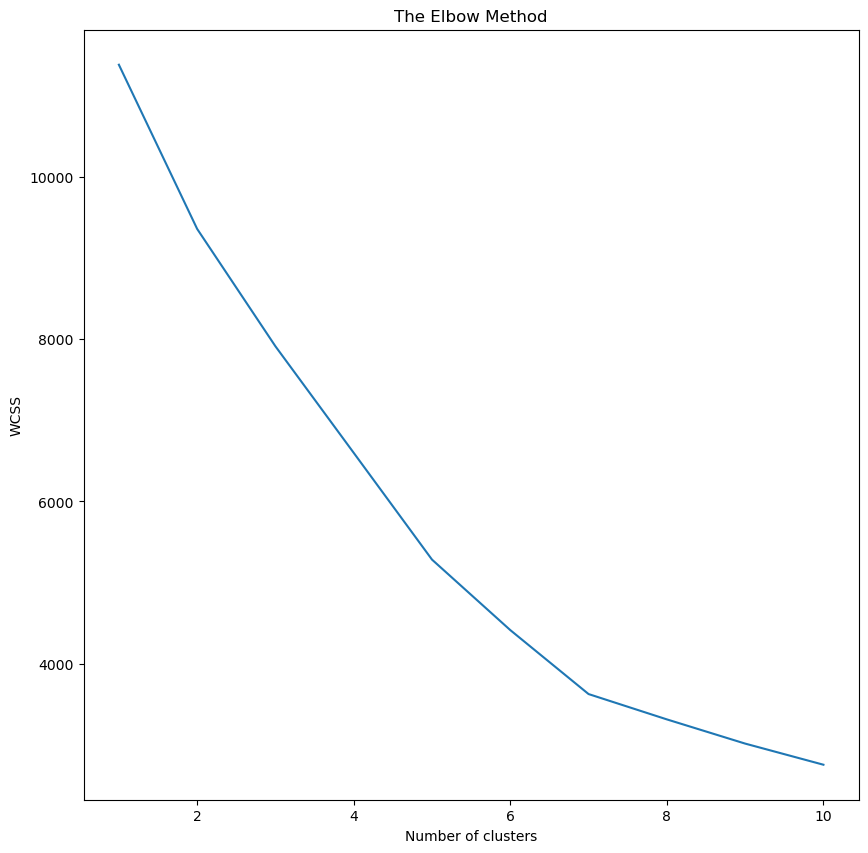

In [27]:
wcss = []  # Within cluster sum of squares (WCSS)
sse = {}

for i in range(1, 11):
    model_01 = KMeans(n_clusters=i, init="k-means++")
    model_01.fit(scaled_features)
    wcss.append(model_01.inertia_)
    sse[i] = model_01.inertia_
    print("For cluster = {}, SSE/WCSS is {}".format(i, sse[i]))

plt.figure(figsize=(10, 10))
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


## Determining the best K - value

In [28]:
kl = KneeLocator(range(1, 11), wcss, curve="convex", direction="decreasing")
print('Best K-value (using KneeLocator) utilizing k-means:',kl.elbow)

Best K-value (using KneeLocator) utilizing k-means: 5


## K-Means Clustering of Audio Features

In [30]:
centers = np.array(model_01.cluster_centers_)
model = KMeans(n_clusters=5, init="k-means++", max_iter=50, n_init=10, random_state=0)
clustered_data = model.fit_predict(scaled_features)

In [31]:
predict_kmeans = model.labels_
print(predict_kmeans)

[1 1 0 ... 1 3 3]


In [32]:
# Frequency count of the Output clusters
unique, counts = np.unique(predict_kmeans, return_counts=True)
print('Unique sample counts per cluster:', dict(zip(unique, counts)))

Unique sample counts per cluster: {0: 984, 1: 797, 2: 4, 3: 103, 4: 9}


In [33]:
#Append the prediction 
df_new["Clusters"] = clustered_data
print("Clusters Assigned : \n")
df_new.head()

Clusters Assigned : 



,filename,sampling_rate,duration,min_pitch,max_pitch,mean_spectral_bandwidth,rms_loudness_db,Clusters
0,187729091.wav,48000,9.069646,153.104935,3995.882812,1761.494220,-18.369985,1
1,187729521.wav,48000,3.962250,153.333115,3996.012207,1452.741787,-20.024362,1
2,187731871.wav,48000,5.313521,152.475082,3992.306885,1940.305070,-24.257099,0
3,187731881.wav,48000,26.605250,152.427460,3996.077881,1744.648435,-21.421558,1
4,187734321.wav,48000,11.974063,152.662949,3993.209961,1957.149901,-26.821197,0


## Organizing Audio Data into Cluster Subdirectories

In [39]:
import os
import shutil
from sklearn.model_selection import train_test_split

source_folder = "D:/echo unsupervised bird redo/part_00"

# Split the data into training and testing sets
train_df, test_df = train_test_split(df_new, test_size=0.2, random_state=42)  # Assuming df_new is your DataFrame with cluster labels

# Function to organize audio files into cluster subdirectories within a folder
def organize_audio_data(df, folder_path):
    for cluster_id in range(5):  # Assuming you have 5 clusters
        # Create a subdirectory for the cluster
        cluster_folder = os.path.join(folder_path, str(cluster_id))
        os.makedirs(cluster_folder, exist_ok=True)
        
        # Get filenames of audio files belonging to the current cluster
        cluster_audio_filenames = df[df['Clusters'] == cluster_id]['filename'].tolist()  # Assuming 'Clusters' is the column containing cluster labels
        
        # Copy audio files to the cluster subdirectory
        for filename in cluster_audio_filenames:
            source_path = os.path.join(source_folder, filename)  # Path of the audio file in the original folder
            destination_path = os.path.join(cluster_folder, filename)  # Destination path within the cluster subdirectory
            shutil.copy(source_path, destination_path)  # Copy the audio file to the cluster subdirectory

# Create Train and Test folders
train_folder = "D:/echo unsupervised bird redo/Train"  # Update with your desired path
test_folder = "D:/echo unsupervised bird redo/Test"  # Update with your desired path
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# Organize training and testing audio data into cluster subdirectories
organize_audio_data(train_df, train_folder)
organize_audio_data(test_df, test_folder)


## File Path and Label Assignment for Training Data

In [40]:
clusters = ['0', '1', '2', '3', '4']
path = 'D:/echo unsupervised bird redo/'
training_file_names = []
training_bird_labels = []

for i in range(0, len(clusters)):
    sub_path = path + 'Train/' + clusters[i] + '/'
    sub_file_names = [os.path.join(sub_path, f) for f in os.listdir(sub_path)]
    sub_bird_labels = [i] * len(sub_file_names)
    training_file_names += sub_file_names
    training_bird_labels += sub_bird_labels

## File Path and Label Assignment for Testing Data

In [41]:
testing_file_names = []
testing_bird_labels = []
for i in range(0, len(clusters)):
    sub_path = path + 'Test/' + clusters[i] + '/'
    sub_file_names = [os.path.join(sub_path, f) for f in os.listdir(sub_path)]
    sub_bird_labels = [i] * len(sub_file_names)
    testing_file_names += sub_file_names
    testing_bird_labels += sub_bird_labels

**Here we clusters audio data using KMeans for unsupervised grouping and then organizes them into distinct clusters. further splited the data into training and testing sets. Now we are extracting MFCC features from the audio files, and then employs AdaBoost, a supervised learning technique, to classify bird sounds based on these features.**

## MFCC Feature Extraction from Audio Files

**The mfcc_extraction function extracts Mel-Frequency Cepstral Coefficients (MFCCs) from a WAV audio file. It uses librosa for feature extraction and pydub for reading the audio. Parameters include filename, hop duration, number of MFCC features, and frames. It computes MFCCs, truncates to the specified frames, and returns a flattened vector of MFCC features.**

In [43]:
import librosa
import numpy as np
from pydub import AudioSegment

def mfcc_extraction(audio_filename, #.wav filename
                    hop_duration, #hop_length in seconds, e.g., 0.015s (i.e., 15ms)
                    num_mfcc, #number of mfcc features
                    num_frames #number of frames
                    ):
    speech = AudioSegment.from_wav(audio_filename) #Read audio data from file
    samples = speech.get_array_of_samples() #samples x(t)
    sampling_rate = speech.frame_rate #sampling rate f 
    
    mfcc = librosa.feature.mfcc(
        y=np.float32(samples),
        sr=sampling_rate,
        hop_length=int(sampling_rate * hop_duration),
        n_mfcc=num_mfcc)
    
    mfcc_truncated = np.zeros((num_mfcc, num_frames), np.float32)
    for i in range(min(num_frames, mfcc.shape[1])):
        mfcc_truncated[:, i] = mfcc[:, i]
        
    #output is a vector including mfcc_truncated.shape[0] * mfcc_truncated.shape[1] elements
    return np.reshape(mfcc_truncated.T, mfcc_truncated.shape[0] * mfcc_truncated.shape[1])

## Extracting MFCC Features for Training and Testing Data

In [44]:
# Create a list of extracted mfcc features
train_mfcc_features = []
test_mfcc_features = []

hop_duration = 0.015
num_frames = 200
num_mfcc = 12

for file_name in training_file_names:
    train_mfcc_features.append(mfcc_extraction(file_name, 
                                                 hop_duration,
                                                 num_mfcc,
                                                 num_frames))

for file_name in testing_file_names:
    test_mfcc_features.append(mfcc_extraction(file_name, 
                                                 hop_duration,
                                                 num_mfcc,
                                                 num_frames))

## Evaluating AdaBoost Classifier with MFCC Features

**The eval_adaboost function evaluates an AdaBoost classifier for bird sound classification using MFCC features. It extracts MFCC features from training and testing audio files, trains an AdaBoost model, and evaluates its performance. The function reports classification metrics such as precision, recall, and F1-score, plots a confusion matrix, and calculates the overall accuracy. Finally, it returns the accuracy score along with training and testing times.**

In [45]:
from sklearn.ensemble import AdaBoostClassifier

def eval_adaboost(num_mfcc):

    # Create a list of extracted mfcc features
    train_mfcc_features = []
    test_mfcc_features = []
    hop_duration = 0.015
    num_frames = 200
    num_mfcc = num_mfcc

    for file_name in training_file_names:
        train_mfcc_features.append(mfcc_extraction(file_name, 
                                                     hop_duration,
                                                     num_mfcc,
                                                     num_frames))

    for file_name in testing_file_names:
        test_mfcc_features.append(mfcc_extraction(file_name, 
                                                     hop_duration,
                                                     num_mfcc,
                                                     num_frames))
        
    ada_model = AdaBoostClassifier(n_estimators=100)
    
    start = time.time()
    ada_model.fit(np.vstack(train_mfcc_features), np.vstack(training_bird_labels))
    end = time.time()
    
    train_time = end - start
    
    start = time.time()
    pred_bird_labels = ada_model.predict(np.vstack(test_mfcc_features))
    end = time.time()
    
    test_time = end - start
    
    print(classification_report(np.vstack(testing_bird_labels), pred_bird_labels, target_names=clusters))
    
    plot_confusion_matrix(ada_model, np.vstack(test_mfcc_features), np.vstack(testing_bird_labels))
    
    print ("overall accuracy : {}".format(accuracy_score(np.vstack(testing_bird_labels), pred_bird_labels)))
    
    return accuracy_score(np.vstack(testing_bird_labels), pred_bird_labels), train_time, test_time


## AdaBoost Classifier Evaluation with Varying Number of MFCCs

              precision    recall  f1-score   support

           0       0.64      0.72      0.67       183
           1       0.60      0.57      0.59       165
           2       0.00      0.00      0.00         1
           3       0.35      0.21      0.27        28
           4       0.00      0.00      0.00         3

    accuracy                           0.61       380
   macro avg       0.32      0.30      0.31       380
weighted avg       0.59      0.61      0.60       380

overall accuracy : 0.6078947368421053
              precision    recall  f1-score   support

           0       0.59      0.29      0.39       183
           1       0.62      0.32      0.42       165
           2       0.00      0.00      0.00         1
           3       0.10      0.71      0.17        28
           4       0.00      0.00      0.00         3

    accuracy                           0.33       380
   macro avg       0.26      0.26      0.20       380
weighted avg       0.56      0.33      

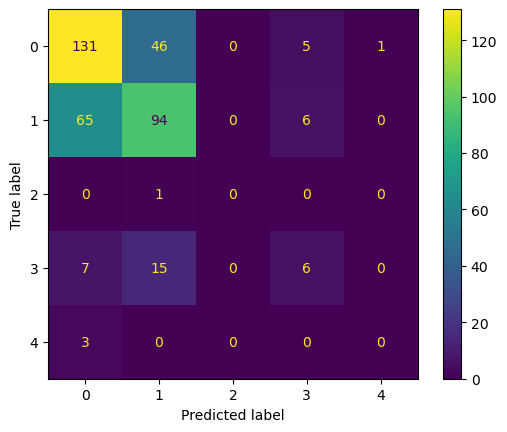

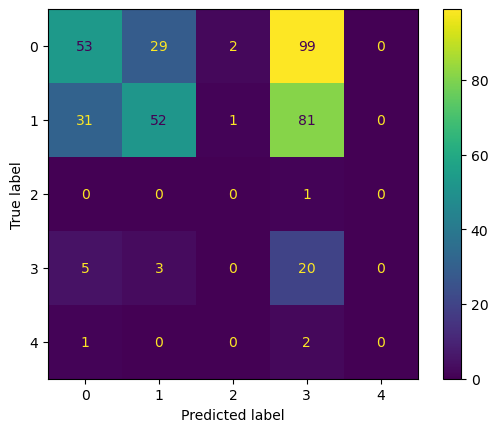

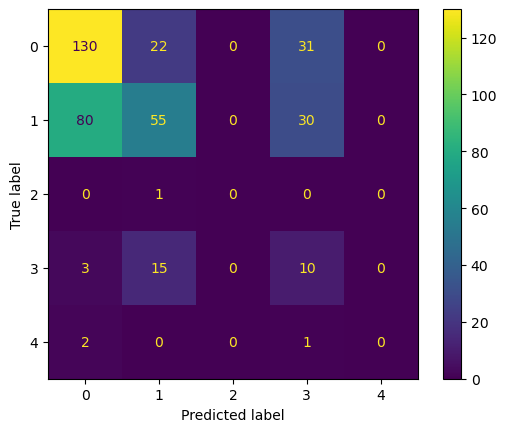

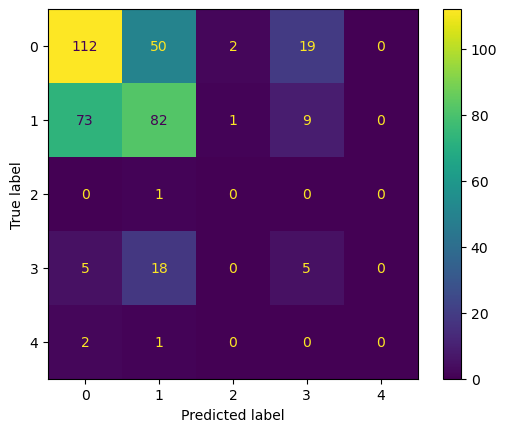

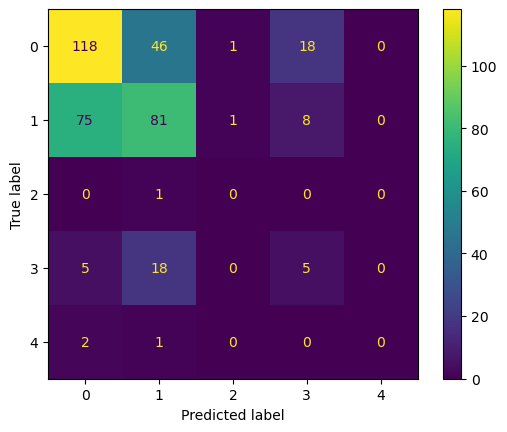

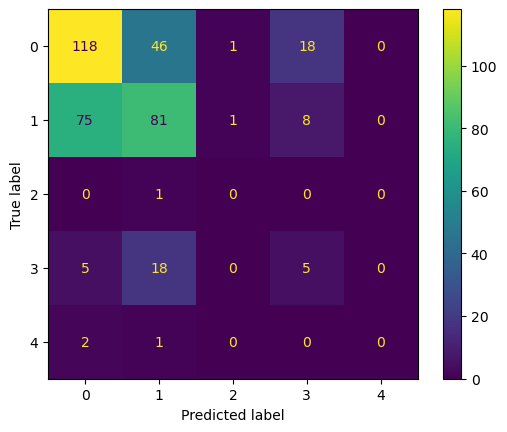

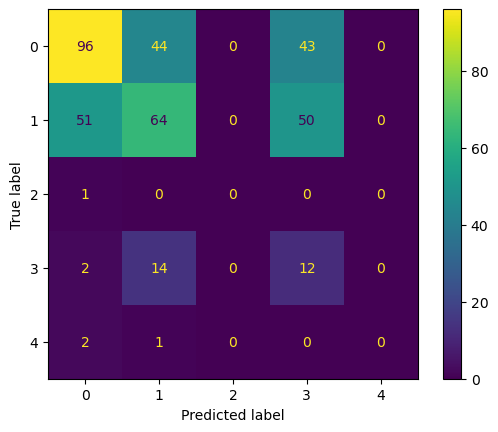

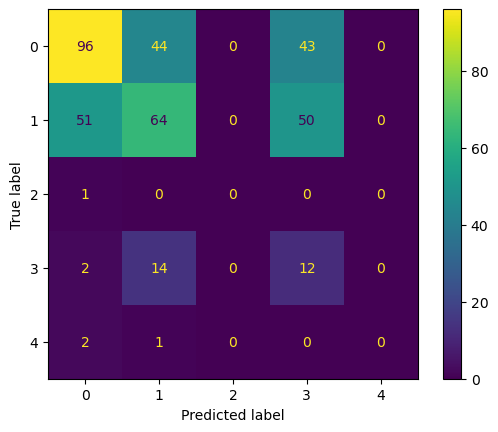

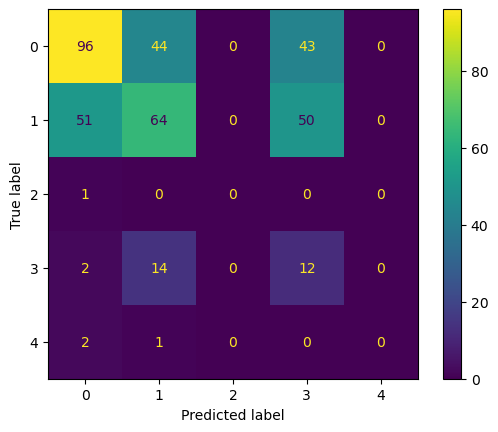

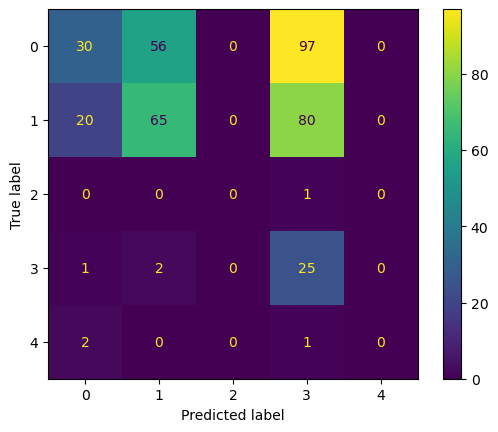

In [46]:
num_mfccs = [12, 14, 16, 18, 20, 22, 24, 26, 28, 30]
ada_accuracy = []
train_time_ada = []
test_time_ada = []
for num_mfcc in num_mfccs:
    accuracy, train_time, test_time = eval_adaboost(num_mfcc)
    ada_accuracy.append(accuracy)
    train_time_ada.append(train_time)
    test_time_ada.append(test_time)